## Imports

In [1]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

%cd /content/drive/MyDrive/GRM_proj/

Mounted at /content/drive
/content/drive/MyDrive/GRM_proj


In [2]:
!pip install igraph
!pip install PyMaxFlow

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from time import perf_counter

In [4]:
import graph_cut as gc
from maxflow.fastmin import aexpansion_grid

## Data

Image shape :  (128, 128, 3)


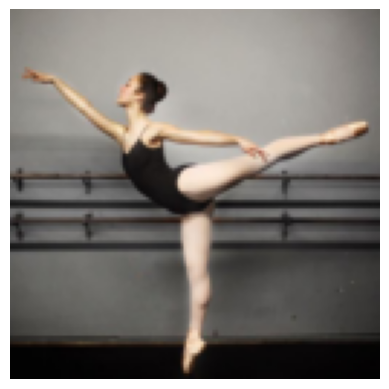

In [5]:
from PIL import Image
import torch
import torchvision.transforms as transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
imsize = 512 if torch.cuda.is_available() else 128
loader = transforms.Compose([transforms.Resize(imsize), transforms.ToTensor()])

def image_loader(image_name):
    image = Image.open(image_name)
    image =  loader(image).unsqueeze(0).to(device, torch.float)[:, :3][0]
    image = image.cpu().numpy().transpose(1,2,0)
    return image

content_img = image_loader("data/images/dance2.png")

print("Image shape : ",content_img.shape)

plt.imshow(content_img)
plt.axis('off');

In [6]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

content_img_flat = content_img.reshape((-1,3))
print("Flat image shape : ",content_img_flat.shape)

n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init="auto").fit(content_img_flat)

Flat image shape :  (16384, 3)


Clustered image shape :  (128, 128)


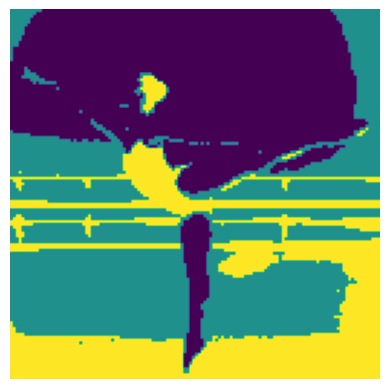

In [7]:
cluster_labels = kmeans.labels_.reshape(content_img.shape[:2])
print("Clustered image shape : ",cluster_labels.shape)

plt.imshow(cluster_labels)
plt.axis('off')
plt.show()

Cluster centers shape :  (3, 3)
Distance array shape :  (3, 128, 128)
Distance image shape :  (128, 128)


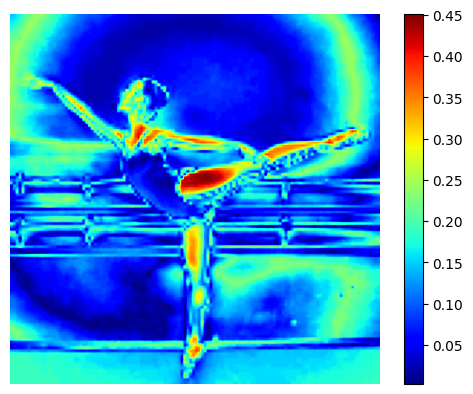

In [8]:
cluster_centers = kmeans.cluster_centers_
print("Cluster centers shape : ",cluster_centers.shape)

# distance to cluster centers
distance_array = np.zeros((n_clusters,imsize,imsize), dtype=np.float32)
distance_img = np.zeros_like(cluster_labels,dtype=np.float32)
print("Distance array shape : ",distance_array.shape)
print("Distance image shape : ",distance_img.shape)

for i, cluster_center in enumerate(cluster_centers):
    distances = np.linalg.norm(content_img - cluster_center, axis=2)
    distance_array[i] = distances
    mask = (cluster_labels == i)
    distance_img[mask] = np.linalg.norm(content_img[mask] - cluster_center, axis=1)

plt.imshow(distance_img.reshape((imsize,imsize)), cmap='jet')
plt.colorbar()
plt.axis('off')
plt.show()

Image shape :  (128, 128, 3)
Distance shape :  (128, 128, 3)
Assignement shape :  (128, 128)


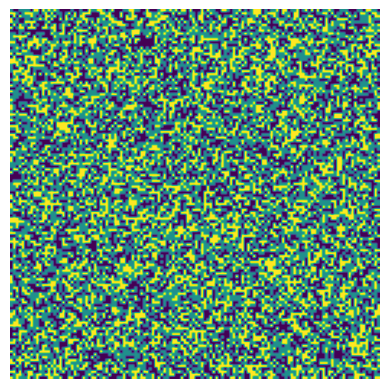

In [9]:
print("Image shape : ",content_img.shape)
height, width, K = imsize, imsize, n_clusters
distances = distance_array.transpose(1,2,0)
random_assignments = np.random.randint(0, K, (height, width))
print("Distance shape : ",distances.shape)
print("Assignement shape : ",random_assignments.shape)
plt.imshow(random_assignments)
plt.axis('off')
plt.show()

Assignement shape :  (128, 128)


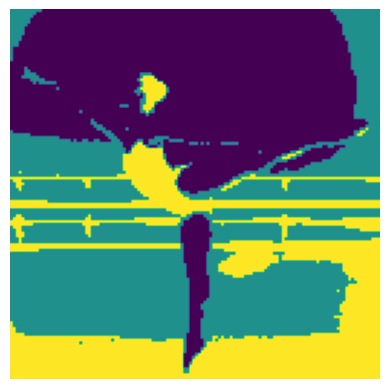

In [10]:
greedy_assignments = np.argmin(distances,axis=2)
print("Assignement shape : ",greedy_assignments.shape)
plt.imshow(greedy_assignments)
plt.axis('off')
plt.show()

## Stochastic assignments

Initial energy :  73117.96075479034


  0%|          | 0/5000 [00:00<?, ?it/s]

Final energy :  68548.88362946454
Mean number of fails :  2.272905759162304


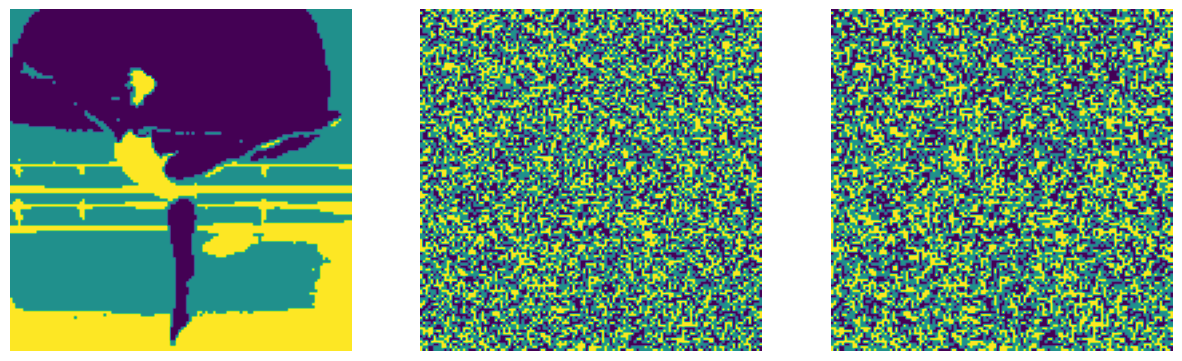

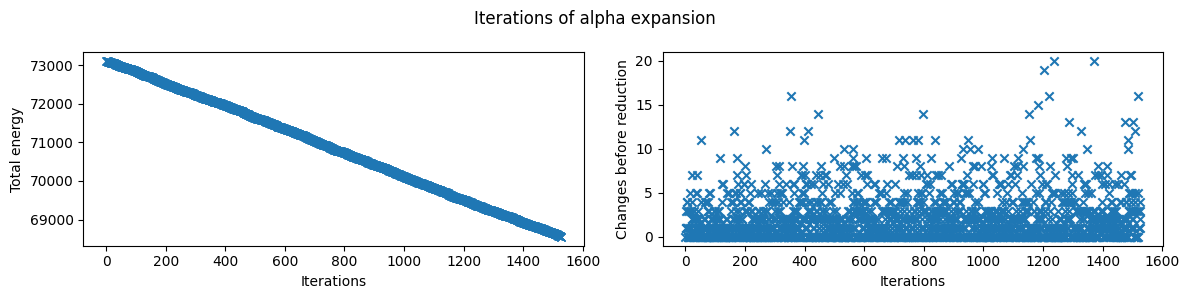

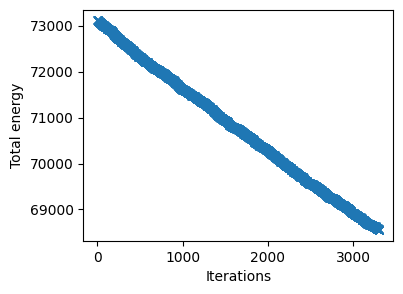

In [ ]:
beta = 1
max_iter = 5000

assignments, energies, fail_counts, computed_energies = gc.alpha_expansion_stochastic(distances, random_assignments, max_iter=max_iter, beta=beta)

print("Mean number of fails : ",np.mean(fail_counts))

gc.plot_images(cluster_labels, random_assignments, assignments)

gc.plot_energy(energies, fail_counts)
gc.plot_energy(computed_energies)

Initial energy :  49806.7612268948


  0%|          | 0/5000 [00:00<?, ?it/s]

Final energy :  48937.38754186267
Mean number of fails :  216.43478260869566


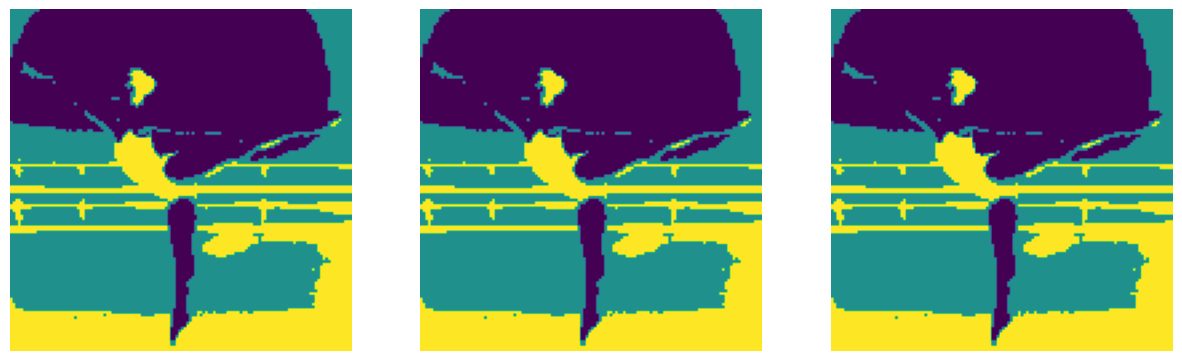

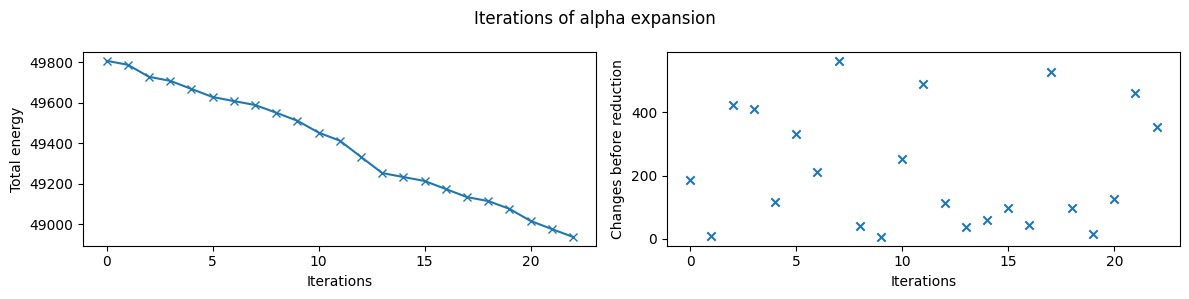

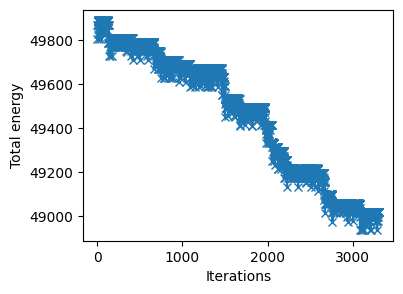

In [ ]:
beta = 10
max_iter = 5000

assignments, energies, fail_counts, computed_energies = gc.alpha_expansion_stochastic(distances, greedy_assignments, max_iter=max_iter, beta=beta)

print("Mean number of fails : ",np.mean(fail_counts))

gc.plot_images(cluster_labels, greedy_assignments, assignments)

gc.plot_energy(energies, fail_counts)
gc.plot_energy(computed_energies)

## Greedy assignments

Initial energy :  73117.96075479034


  0%|          | 0/5000 [00:00<?, ?it/s]

Final energy :  63161.60144751798
Mean number of fails :  0.8152450090744101


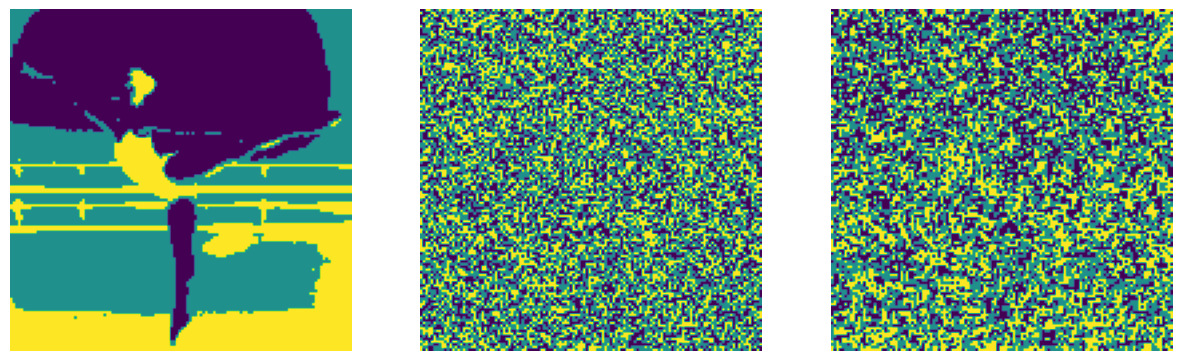

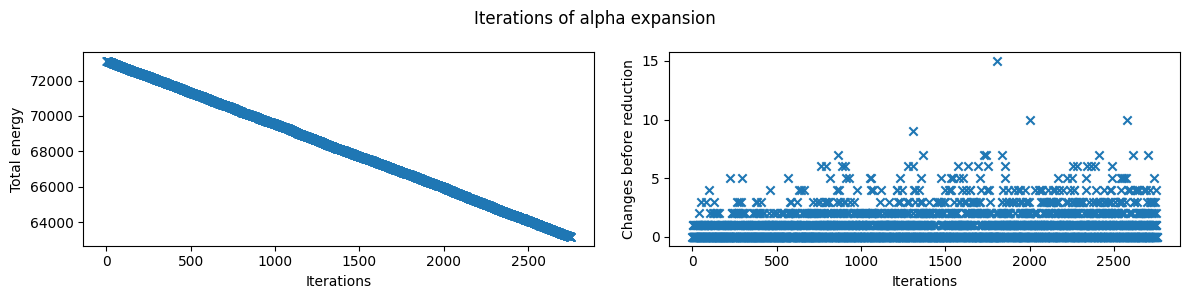

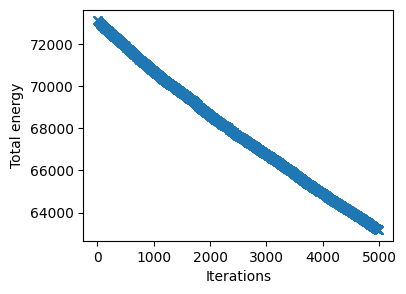

In [ ]:
beta = 1
max_iter = 5000

assignments, energies, fail_counts, computed_energies = gc.alpha_expansion_greedy(distances, random_assignments, max_iter=max_iter, beta=beta)

print("Mean number of fails : ",np.mean(fail_counts))

gc.plot_images(cluster_labels, random_assignments, assignments)

gc.plot_energy(energies, fail_counts)
gc.plot_energy(computed_energies)

Initial energy :  49806.7612268948


  0%|          | 0/5000 [00:00<?, ?it/s]

Final energy :  48190.10469637299
Mean number of fails :  118.07142857142857


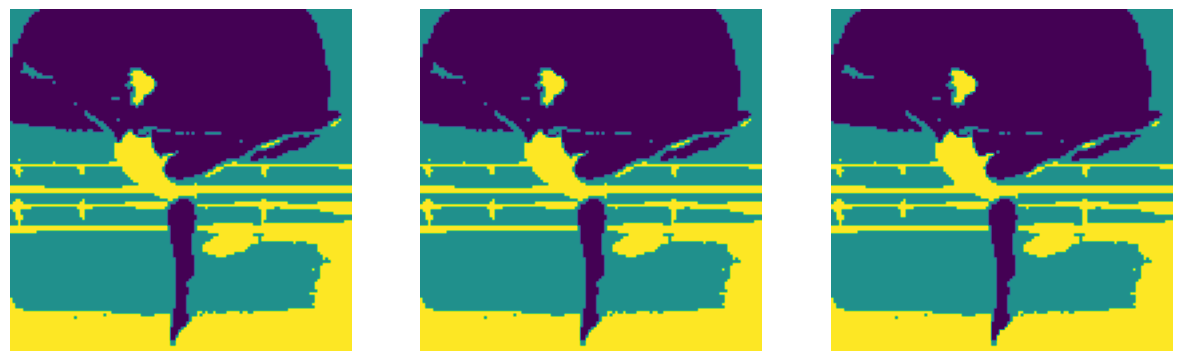

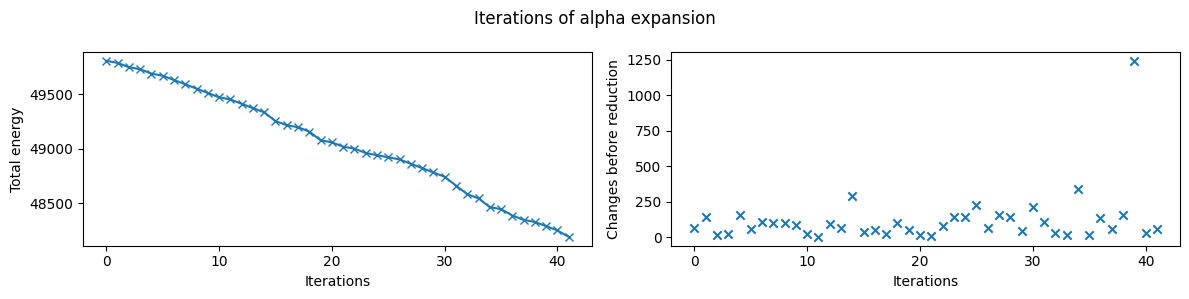

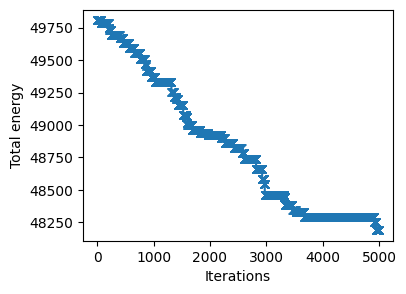

In [ ]:
beta = 10
max_iter = 5000

assignments, energies, fail_counts, computed_energies = gc.alpha_expansion_greedy(distances, greedy_assignments, max_iter=max_iter, beta=beta)

print("Mean number of fails : ",np.mean(fail_counts))

gc.plot_images(cluster_labels, greedy_assignments, assignments)

gc.plot_energy(energies, fail_counts)
gc.plot_energy(computed_energies)

## Alpha expansion

### With networkx

In [ ]:
for max_cycles in [1,2]:
  for beta in [1e-2, 1e-1, 1]:
    print("")
    print("Max cycles : ", max_cycles)
    print("Beta : ", beta)

    assignments, energies = gc.alpha_expansion(distances, random_assignments, max_cycles=max_cycles, beta=beta)

    gc.plot_images(cluster_labels, random_assignments, assignments)
    gc.plot_energy(energies)


Max cycles :  10
Beta :  10000


  0%|          | 0/30 [00:00<?, ?it/s]

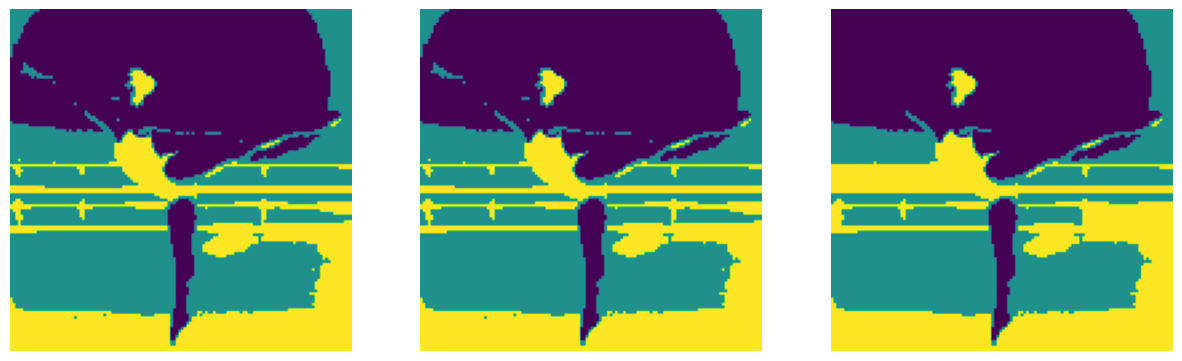

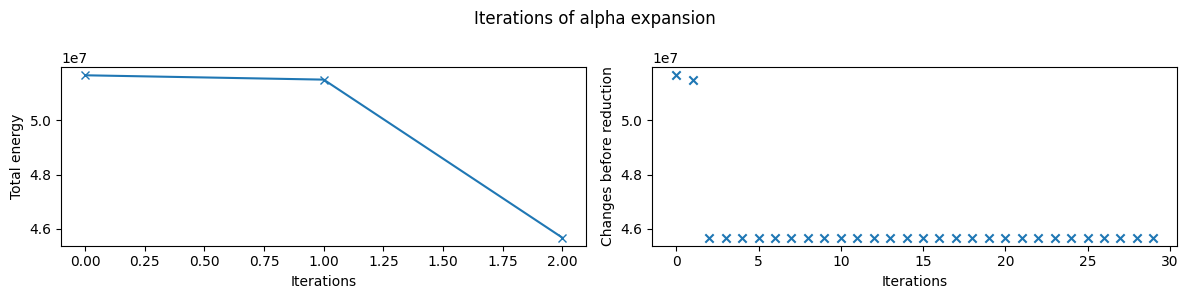

In [14]:
for max_cycles in [10]:
  for beta in [10000]:
    print("")
    print("Max cycles : ", max_cycles)
    print("Beta : ", beta)

    assignments, energies, total_energies = gc.alpha_expansion(distances, greedy_assignments, max_cycles=max_cycles, beta=beta)

    gc.plot_images(cluster_labels, greedy_assignments, assignments)
    gc.plot_energy(energies, total_energies)

### With igraph


Max cycles :  1
Beta :  0.01


  0%|          | 0/1 [00:00<?, ?it/s]

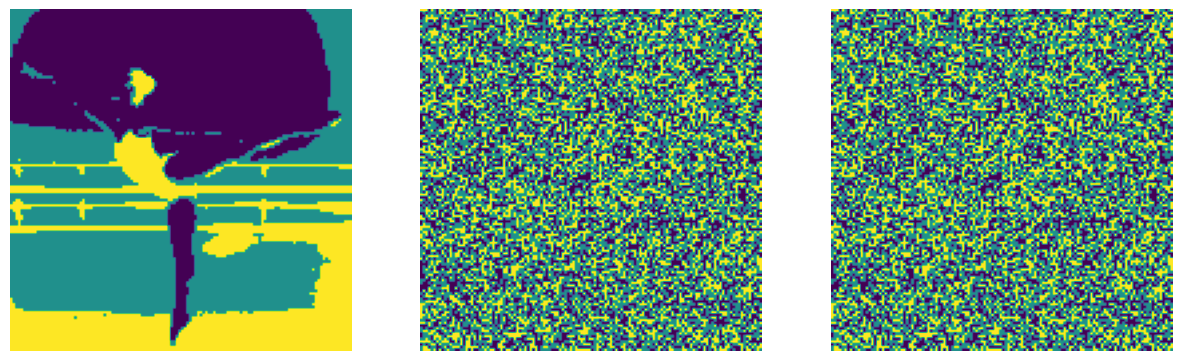

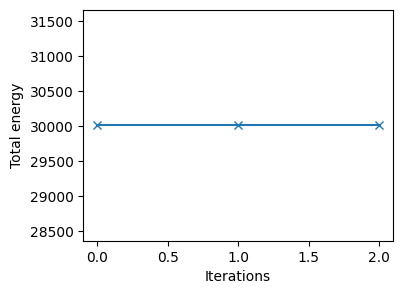


Max cycles :  1
Beta :  0.1


  0%|          | 0/1 [00:00<?, ?it/s]

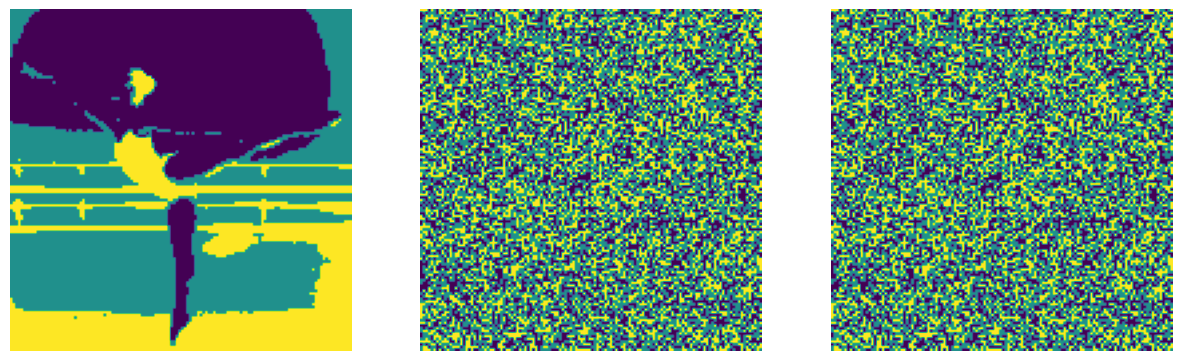

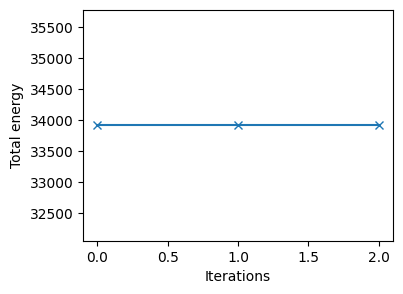


Max cycles :  1
Beta :  1


  0%|          | 0/1 [00:00<?, ?it/s]

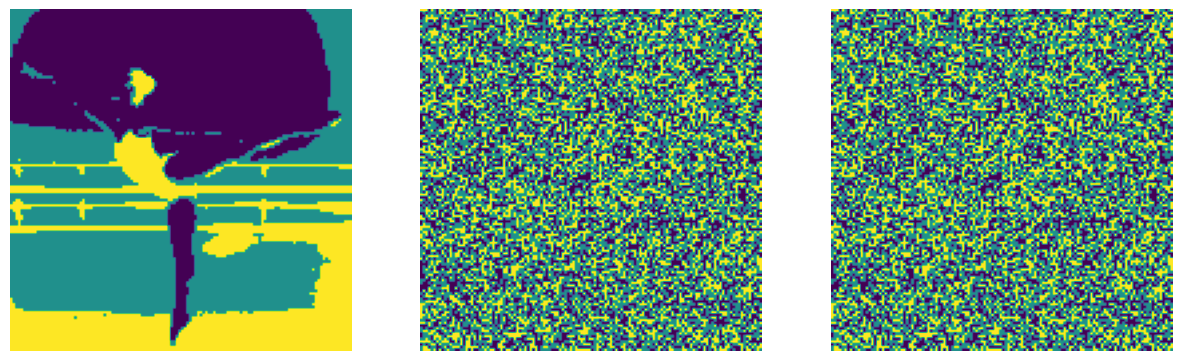

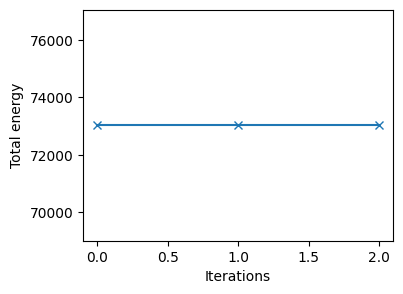


Max cycles :  2
Beta :  0.01


  0%|          | 0/2 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
for max_cycles in [1,2]:
  for beta in [1e-2, 1e-1, 1]:
    print("")
    print("Max cycles : ", max_cycles)
    print("Beta : ", beta)

    assignments, energies = gc.alpha_expansion(distances, random_assignments, max_cycles=max_cycles, beta=beta, do_igraph=True)

    gc.plot_images(cluster_labels, random_assignments, assignments)
    gc.plot_energy(energies)

## Pymaxflow aexpansion


Max cycles :  None
Beta :  0.01
Done in 0.011737949000234948 s


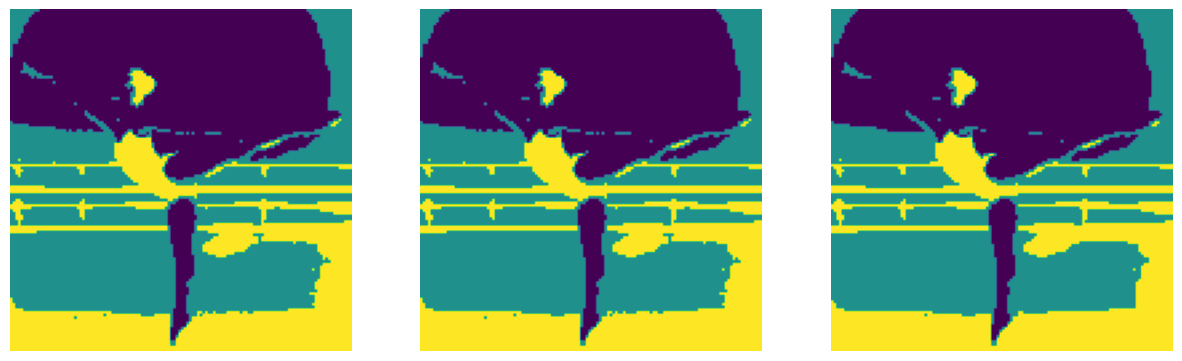


Max cycles :  None
Beta :  0.1
Done in 0.018827018000592943 s


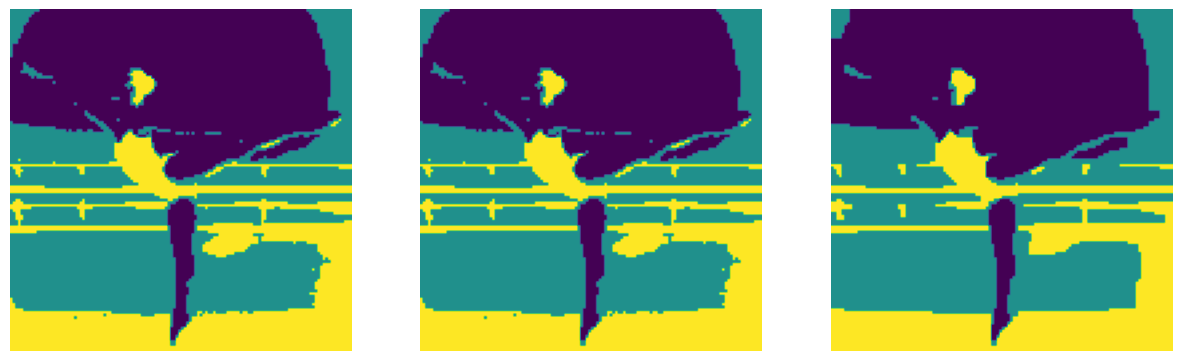


Max cycles :  None
Beta :  1
Done in 0.03595198699986213 s


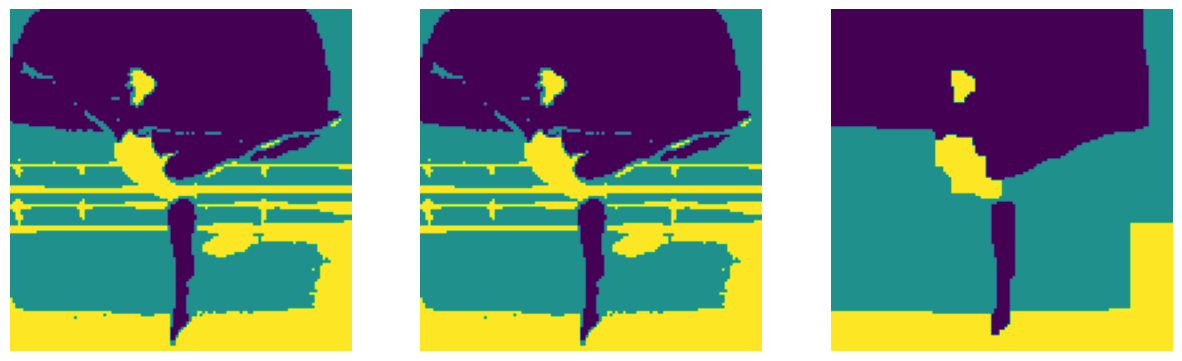

In [ ]:
for max_cycles in [None]:
  for beta in [1e-2,1e-1,1]:
    print("")
    print("Max cycles : ", max_cycles)
    print("Beta : ", beta)

    smooth_term = beta * (1 - np.eye(n_clusters))
    data_term = distances.copy().astype(np.double)

    t1 = perf_counter()
    labels = aexpansion_grid(data_term, smooth_term, max_cycles=max_cycles)
    t2 = perf_counter()
    print(f"Done in {(t2-t1)} s")

    gc.plot_images(cluster_labels, greedy_assignments, labels)